## CASTOR Feature Extraction Method (k-mer based)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import re
from IPython.display import display
import utils
!pip install biopython
!pip install git+https://github.com/bioinfoUQAM/CASTOR_KRFE
    
import os, errno
from castor_krfe import data
from castor_krfe import extraction
from castor_krfe import evaluation
from castor_krfe import utils

In [2]:
# Label extraction to csv for CASTOR
labels_csv = 'content/zoonotic_labels.csv'
if not os.path.exists(labels_csv):
    pdnonzoo = utils.loadFASTA("./content/NonZoonoticVirusesStringent0_0_GlobalViromeProject.fasta")
    pdiszoo = utils.loadFASTA("./content/ZoonoticVirusSequencesStringentGlobalViromeProject.fasta")

    import csv
    lines = []
    for x in pdiszoo['ID']:
        lines.append([x,"Zoonotic"])
    for x in pdnonzoo['ID']:
        lines.append([x,"NonZoonotic"])

    with open(labels_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(lines)

### Default accuracy from online CASTOR tool --- 64%

In [3]:
# Link to online CASTOR results with optimised classifier: 
# http://castor.bioinfo.uqam.ca/index.php?castor=optimize&jobId=EXF3BK1F69I3
from IPython.display import Image
Image(url="castor_output/CASTORresults.png")

### Try improve performance

In [4]:
# Try reproduce/improve on these results
def run_castor(fasta_file, class_file_csv, output_dir="castor_output", threshold=1, k_min=5, k_max=5, features_min=1, features_max=50):
    try:
        os.makedirs(output_dir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    fig_file = os.path.join(output_dir,"castor_out")
    if not output_dir.endswith("/"): output_dir += "/"
    kmers_file = os.path.join(output_dir,'Kmers.txt')
    model_file = os.path.join(output_dir,'model.pkl')
    if not class_file_csv:
        raise ValueError("CSV class file is required for this mode")

    T = threshold

    ############
    ## Train ###
    ############
    print("\nTraining mode\n")
    # Get training dataset
    print("Loading of the training dataset...")
    training_data = data.generateLabeledData(fasta_file, class_file_csv)

    ###########################
    ### FEATURE EXTRACTION  ###
    ###########################
    best_k_mers, best_k_length = extraction.extractKmers(T, training_data,
                                                         k_min, k_max, 
                                                         features_min, features_max, 
                                                         fig_file, kmers_file)
    print("Identified k =", best_k_length)
    print("Identified k-mers  =", best_k_mers)

    ##################
    ### EVALUATION ###
    ##################
    evaluation.cross_validation(training_data, best_k_mers)
    model = evaluation.train_model(training_data, best_k_mers) 
    utils.save_model(model, model_file)

Search over k-mer features lengths from 3 to 10, retaining up to 128 features total.

In [5]:
# Uncomment this to re-run CASTOR's feature extraction
#run_castor("./content/VirusesJoinedSet.fasta","./content/zoonotic_labels.csv","castor_output",
#           k_min=3, k_max=10, features_min=1, features_max=128)
Image(url="castor_output/castor_out.png")

In [6]:
# Let's try do our own analysis on the best feature set produced by CASTOR
from castor_krfe import matrices
from sklearn.preprocessing import LabelEncoder
kmers_file = "./castor_output/Kmers.txt"
best_k_mers = utils.fetch_list_from_file(kmers_file)
best_k_length = len(best_k_mers[0])
XY_raw = data.generateLabeledData("./content/VirusesJoinedSet.fasta","./content/zoonotic_labels.csv")
X, y = matrices.generateXYMatrice(XY_raw, best_k_mers, best_k_length)
y = LabelEncoder().fit_transform(y)

C:\ProgramData\Anaconda3\lib\site-packages\Bio\Seq.py:165: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


### Classes appear slightly more separable using the new features
This is based on a 3D visualisation, based on the test accuracy in the following sections they are more separable in higher dimensions than they appear here.

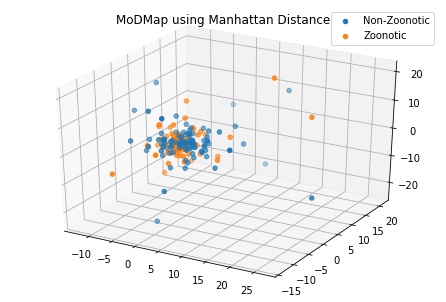

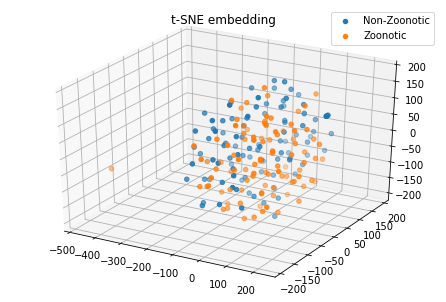

In [7]:
# Visualise data (again)
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold

# MultiDimensional Scaling (MDS) with Manhattan pairwise distances (as per Kameris)
D = pairwise_distances(np.array(X), metric="manhattan", n_jobs=3)
embedding = MDS(n_components=3, dissimilarity="precomputed", random_state=42)
vizData = embedding.fit_transform(D)

# Plot
fig = plt.figure()
ax = Axes3D(fig)
vizDataNonZoo = vizData[y==0,:]
vizDataZoo = vizData[y==1, :]
ax.scatter(vizDataNonZoo[:,0],vizDataNonZoo[:,1],vizDataNonZoo[:,2], label="Non-Zoonotic")
ax.scatter(vizDataZoo[:,0],vizDataZoo[:,1],vizDataZoo[:,2], label="Zoonotic")
ax.legend()
ax.set_title("MoDMap using Manhattan Distance")
plt.show();

# t-SNE embedding
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
vizData = tsne.fit_transform(X)
fig = plt.figure()
ax = Axes3D(fig)
vizDataNonZoo = vizData[y==0,:]
vizDataZoo = vizData[y==1, :]
ax.scatter(vizDataNonZoo[:,0],vizDataNonZoo[:,1],vizDataNonZoo[:,2], label="Non-Zoonotic")
ax.scatter(vizDataZoo[:,0],vizDataZoo[:,1],vizDataZoo[:,2], label="Zoonotic")
ax.legend()
ax.set_title("t-SNE embedding")
plt.show();

### Training accuracy - Linear SVM 98%

Train Accuracy: 0.9801
[[ 96   4]
 [  0 101]]


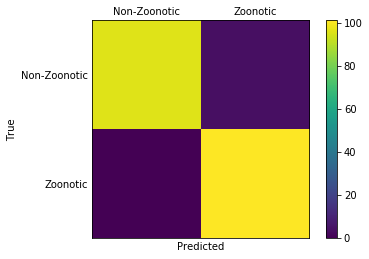

In [8]:
from sklearn.svm import SVC
clf = SVC(kernel="linear", C=1)
clf.fit(X, y)
pred = clf.predict(X)
train_accuracy = (y==pred).sum() / len(y)
print("Train Accuracy: %.4f"%train_accuracy)

from sklearn.metrics import confusion_matrix
labels = ['Non-Zoonotic', 'Zoonotic']
cm = confusion_matrix(y, pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Test Accuracy - Linear SVM > 90%
XGBoost accuracy is bad, but Linear SVM performs gets > 90% accuracy.
The features extracted by CASTOR were chosen based on the relative importance under a linear model (see https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), so this makes sense.

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import numpy as np
import skopt
 
# ignore deprecation warnings
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

    test_acc = 0
    rep = 1
    test_accs = []
    f_scores = []
    skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    X, y = np.array(X), np.array(y)
    for train_index, test_index in skf.split(X,y):
      X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    #for i in range(rep):
      #X, y = shuffle(X, y)
      #X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2) 
      clf = SVC(kernel="linear", C=1)
      #clf = XGBClassifier(max_depth=64, min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0)#, n_estimators=50)#, learning_rate=0.1, n_estimators=100)
      clf.fit(X_train, y_train)
      pred = clf.predict(X_train)
      accuracy = (y_train==pred).sum() / len(y_train)

      pred = clf.predict(X_test)
      accuracy = (y_test==pred).sum() / len(y_test)
      test_accs.append(accuracy)
      f = f1_score(y_test, pred, average='macro')
      f_scores.append(f)
    test_accs = np.array(test_accs)
    f_scores = np.array(f_scores)
    print("Stratified K-Fold Split")
    print("Test Accuracy: %.4f +/- %.4f"%(test_accs.mean(),test_accs.std()))
    print("Min: %.4f, Max: %.4f"%(test_accs.min(),test_accs.max()))
    print("\nF1 Score: %.4f +/- %.4f"%(f_scores.mean(),f_scores.std()))
    print("Min: %.4f, Max: %.4f"%(f_scores.min(),f_scores.max()))

Stratified K-Fold Split
Test Accuracy: 0.9305 +/- 0.0841
Min: 0.7000, Max: 1.0000

F1 Score: 0.9298 +/- 0.0847
Min: 0.6970, Max: 1.0000


Potential problems: the features were chosen over the entire dataset, so we could be leaking information to the model (even if the model is only trained on a non-overlapping subset as above).